In [638]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import imblearn

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import plot_importance
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import auc, precision_recall_curve

pd.set_option('display.max_columns', None)

Reading in prepared data

In [368]:
train_college_imp = pd.read_csv('../data/train_college_imp.csv')

test_college_imp = pd.read_csv('../data/test_college_imp.csv')

This cell creates a feature that captures whether or not the student graduated from a four year college and removes some features that may leak information during modelling.  

In [369]:
#subsetting those that graduated from a 4yr college and those that did not in train set.  
imp_coll_4yr_train = train_college_imp[(train_college_imp.graduated_Y == 1) & (train_college_imp.ps_level == 1)]
imp_not_coll_train = train_college_imp[(train_college_imp.graduated_Y != 1) | (train_college_imp.ps_level != 1)]

#creating target column indicating 4yr college graduation status
imp_coll_4yr_train['target'] = 1
imp_not_coll_train['target'] = 0

#list of features to drop that will corrupt modelling
drop_list_2 = ['ps_level','wages_cont', 'graduated_Y','Unnamed: 0']

#dropping features
drop_stuff(imp_coll_4yr_train,drop_list_2)
drop_stuff(imp_not_coll_train,drop_list_2)

#rejoining features of training dataset
imp_training = pd.concat([imp_coll_4yr_train,imp_not_coll_train])

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

Same manipulations as above but to the test set.

In [370]:
#subsetting those that graduated from a 4yr college and those that did not in test set.  
imp_coll_4yr_test = test_college_imp[(test_college_imp.graduated_Y == 1)&(test_college_imp.ps_level == 1)]
imp_not_coll_test = test_college_imp[(test_college_imp.graduated_Y != 1)|(test_college_imp.ps_level != 1)]

#creating target column indicating 4yr college graduation status
imp_coll_4yr_test['target'] = 1
imp_not_coll_test['target'] = 0

#dropping features from test set that would corrupt modelling
drop_stuff(imp_coll_4yr_test, drop_list_2)
drop_stuff(imp_not_coll_test, drop_list_2)

#rejoining features of training dataset
imp_testing = pd.concat([imp_coll_4yr_test,imp_not_coll_test])

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

In [ ]:
doing last 

In [635]:
imp_training.describe()

literacy_home  risk_factors       math_b    reading_b  math_conf_b  \
count    7920.000000   7920.000000  7920.000000  7920.000000  7920.000000   
mean        2.309722      0.791540    53.124197    52.943163     0.102063   
std         0.800559      0.895671     9.316385     9.335767     0.864150   
min         0.000000      0.000000    19.380000    24.910000    -1.831000   
25%         2.000000      0.000000    47.027500    46.720000    -0.525150   
50%         2.000000      1.000000    53.480000    53.370000     0.056000   
75%         3.000000      1.000000    59.580000    59.410000     0.571000   
max         3.000000      5.000000    86.680000    78.760000     1.772000   

       verbal_confidence     writing       sports     by_xcurr     homework  \
count        7920.000000  7920.00000  7920.000000  7920.000000  7920.000000   
mean            0.089203     0.25321     1.137753     1.160985    10.432449   
std             0.841581     0.85927     1.215649     1.310865     7.215670   
min            -2.197000    -1.84700     0.000000     0.000000     0.000000   
25%            -0.453000    -0.22110     0.000000     0.000000     5.000000   
50%             0.090750     0.24100     1.000000     1.000000     9.000000   
75%             0.561025     0.81200     2.000000     2.000000    14.000000   
max             1.596000     1.95100     7.000000     8.000000    45.000000   

        hedonics_b  hours_working_b  edu_confidence       math_1  \
count  7920.000000      7920.000000     7920.000000  7920.000000   
mean      3.320202         1.023864        6.490657    52.503432   
std       2.136283         1.623188        1.363817     9.622204   
min       0.000000         0.000000        1.000000    22.640000   
25%       2.000000         0.000000        6.000000    45.830000   
50%       3.000000         0.000000        6.000000    52.710000   
75%       4.000000         2.000000        7.000000    59.600000   
max       8.000000         9.000000        9.000000    79.850000   

       math_status_1     f1_xcurr  hours_working_1   hedonics_1  math_conf_1  \
count    7920.000000  7920.000000      7920.000000  7920.000000  7920.000000   
mean        5.309596     2.408838         2.824621     2.910985     0.051313   
std         0.993276     1.837858         2.398262     1.796091     0.904748   
min         1.000000     0.000000         0.000000     0.000000    -2.039000   
25%         5.000000     1.000000         0.000000     2.000000    -0.510000   
50%         6.000000     2.000000         3.000000     3.000000    -0.001000   
75%         6.000000     4.000000         4.000000     4.000000     0.528000   
max         6.000000     9.000000         9.000000     8.000000     1.811000   

        hs_ac_load       hs_gpa       effort      testing   v_facility  \
count  7920.000000  7920.000000  7920.000000  7920.000000  7920.000000   
mean     25.536490     4.379545    36.020909   158.574747   179.065174   
std       3.900347     1.297373     8.059862    25.955988    55.231880   
min       6.000000     0.000000     6.000000    75.000000    26.140000   
25%      24.000000     4.000000    31.000000   141.000000   145.710000   
50%      26.000000     5.000000    35.000000   160.000000   181.515500   
75%      28.000000     5.000000    40.000000   177.000000   219.400000   
max      34.000000     6.000000    74.000000   231.000000   315.040000   

        m_facility   academic_p  iq_by_concientiousness  delinquency  \
count  7920.000000  7920.000000             7920.000000  7920.000000   
mean    284.103091   161.579167            17103.145278     4.957525   
std      86.362937    64.198611             6147.677138     6.420043   
min      26.530000     0.000000              917.600000     0.000000   
25%     226.587500   119.000000            12928.677500     0.000000   
50%     293.075000   160.000000            16703.741000     3.500000   
75%     352.800000   200.000000            20609.590000     7.000000   
max     479.100000   420

with the addition of the 'target', one last bit of exploratory visualization

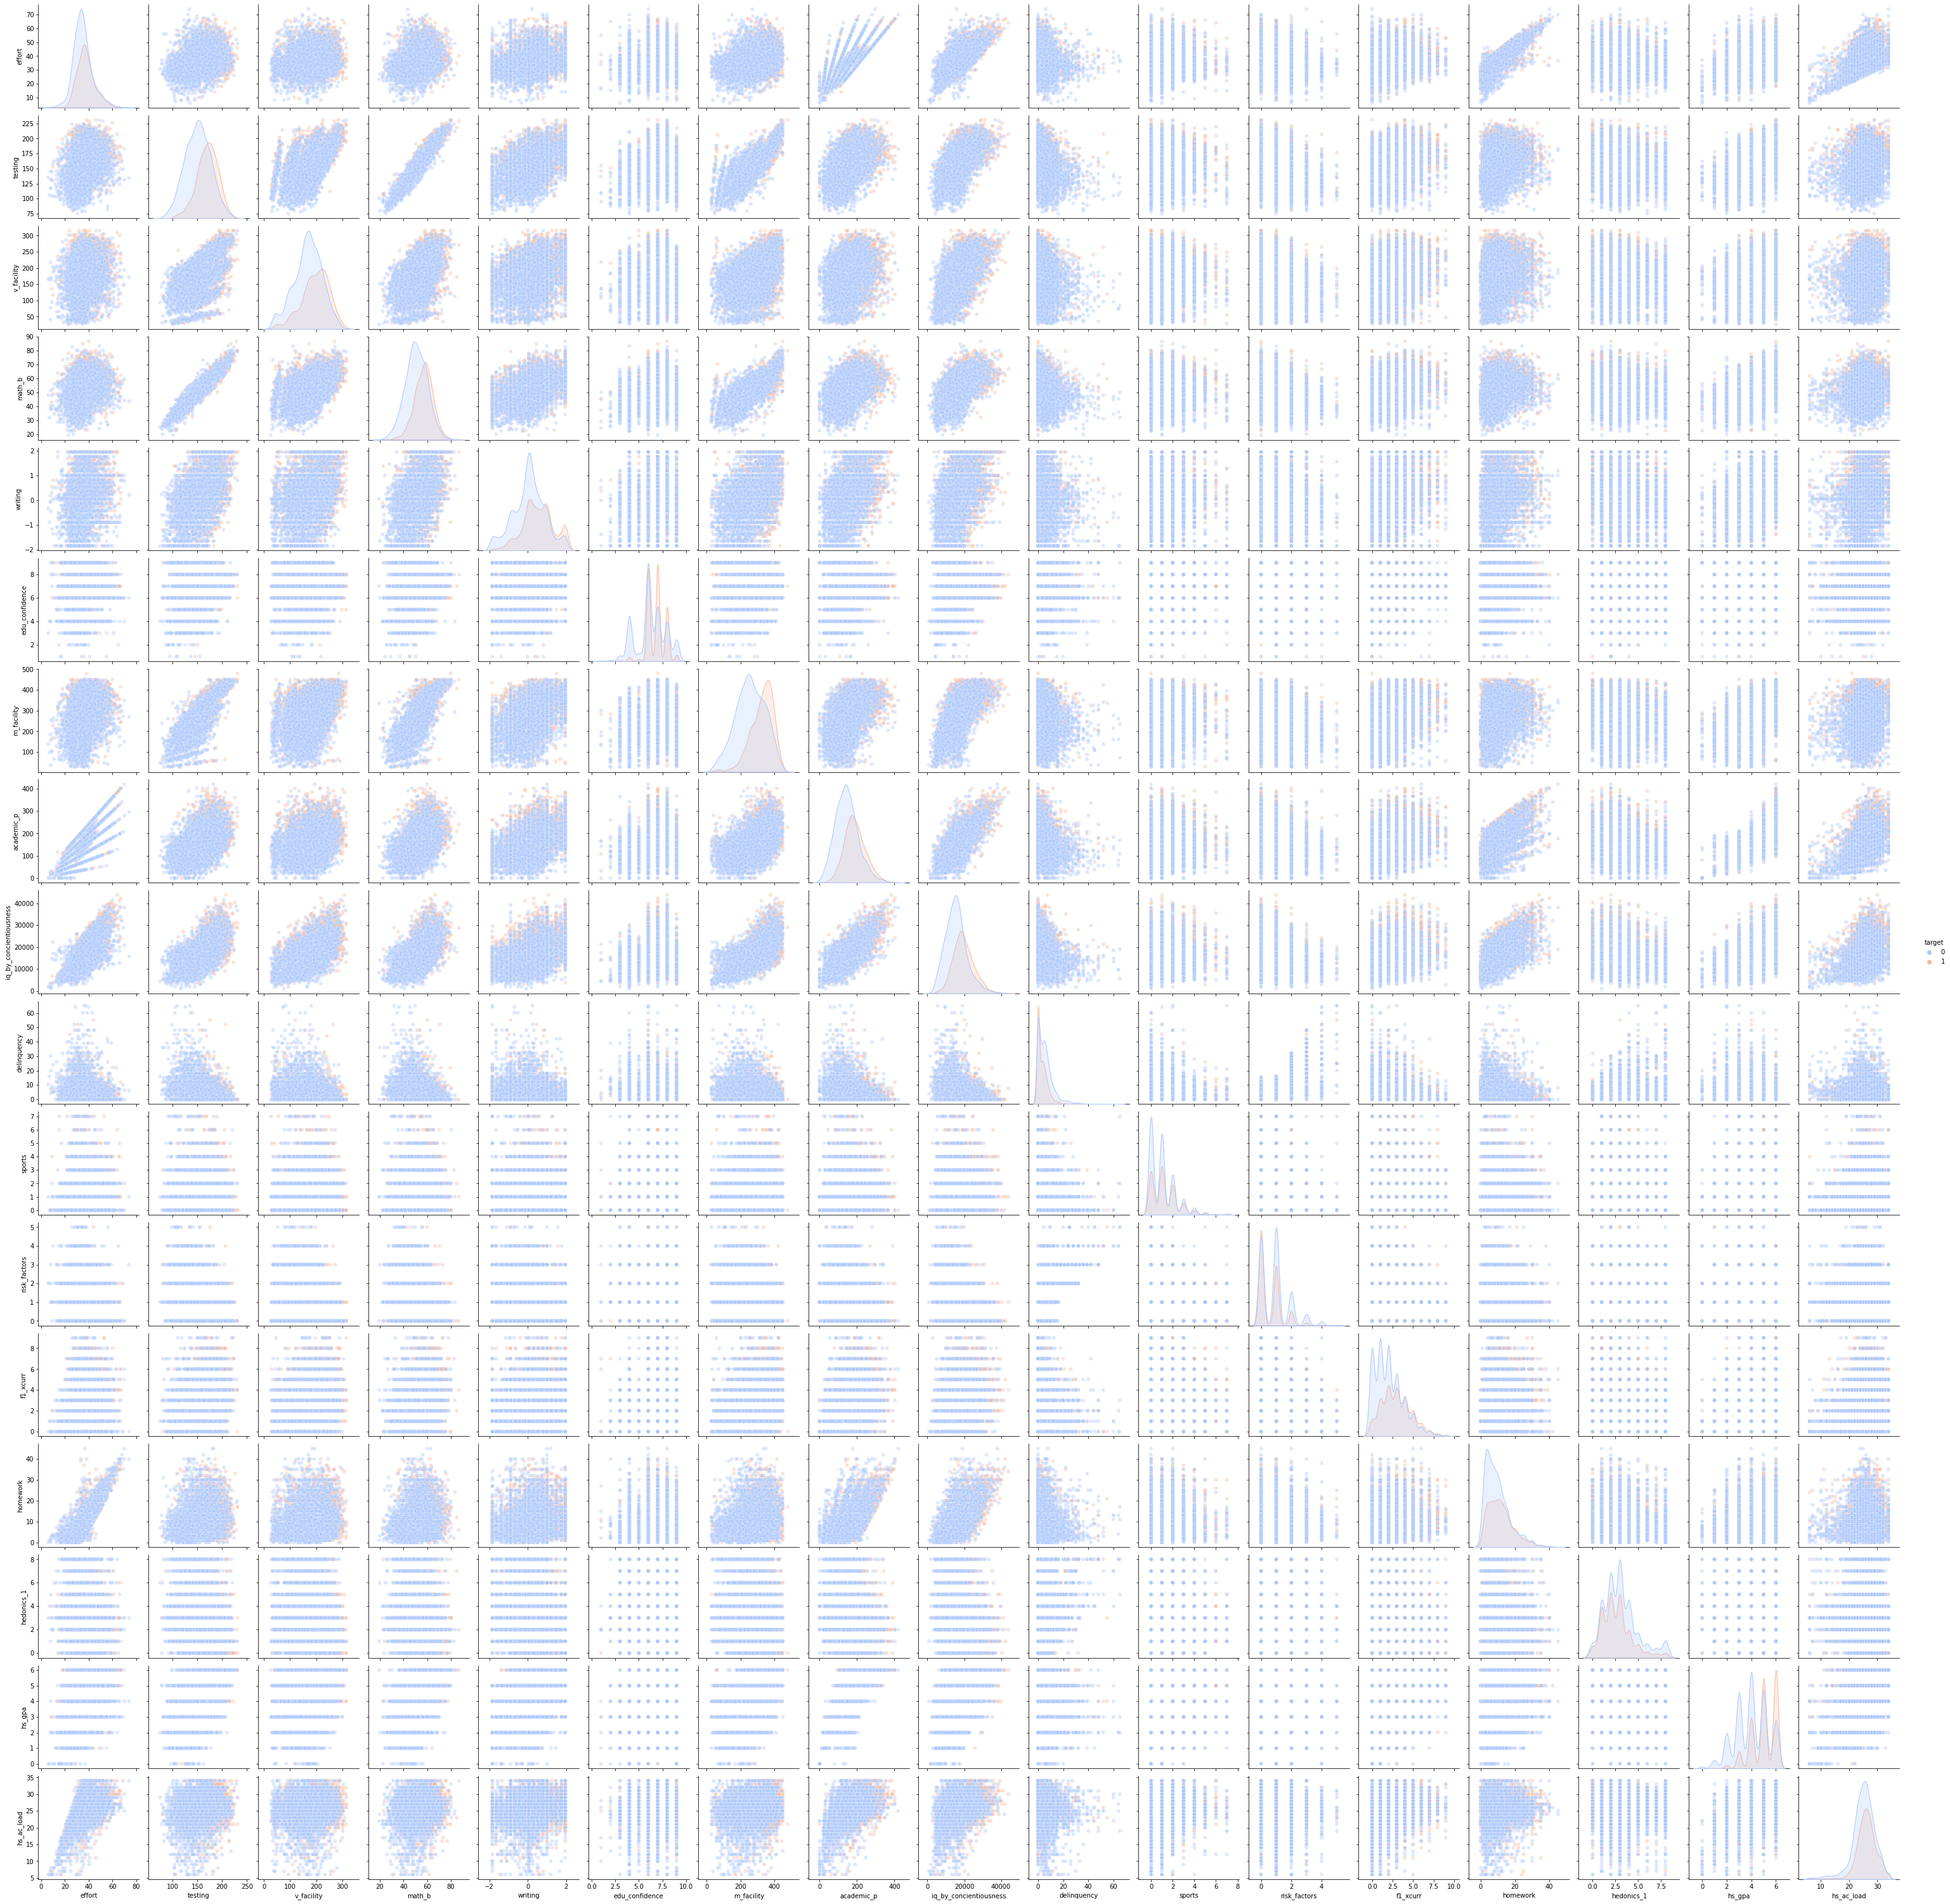

In [308]:
imp_features = imp_training[[ 'target','effort', 'testing', 'v_facility','math_b','writing','edu_confidence',
       'm_facility', 'academic_p', 'iq_by_concientiousness', 'delinquency','sports','risk_factors','f1_xcurr','homework',
                'hedonics_1','hs_gpa','hs_ac_load',]]

sns.pairplot(imp_features, hue = 'target', diag_kind = 'kde', palette= 'coolwarm', plot_kws=dict(alpha = 0.4),
                   diag_kws=dict(shade=True))

Separating target and features in training set.

In [309]:
imp_training_y = imp_training.target
imp_training_x = imp_training.drop(columns = 'target', axis = 1)

Separating target and features in test set

In [310]:
imp_testing_y = imp_testing.target
imp_testing_x = imp_testing.drop(columns = 'target')

Looking at class imbalance. Class imbalance is not severe enough to warrant upsampling.

In [311]:
print(f'decimal fraction of positive and negative target for training set: \n{imp_training.target.value_counts(normalize = True)}')
print(f'decimal fraction of positive and negative target for testing set: \n{imp_testing.target.value_counts(normalize = True)}')


decimal fraction of positive and negative target for training set: 
0    0.612879
1    0.387121
Name: target, dtype: float64
decimal fraction of positive and negative target for testing set: 
0    0.601212
1    0.398788
Name: target, dtype: float64


Creating a series of training and testing sets with 15, 20 and 25 best features, as well as a sets with minimal features, but that will be easy to interpret.

### kbest 15 features

In [312]:
selector = SelectKBest(f_classif, k=15) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb15 = imp_training_x[selected_columns]
X_test_kb15 = imp_testing_x[selected_columns]
print(X_train_kb15.shape, X_test_kb15.shape)

(7920, 15) (1981, 15)


In [313]:
X_test_kb15.columns

Index(['risk_factors', 'math_b', 'reading_b', 'writing', 'edu_confidence',
       'math_1', 'math_status_1', 'f1_xcurr', 'hs_gpa', 'testing',
       'v_facility', 'm_facility', 'academic_p', 'iq_by_concientiousness',
       'delinquency'],
      dtype='object')

kbest 15 provides a pretty lean set that, not surprisingly,  seems to prioritize academic ability.

### k best 20 features

In [314]:
selector = SelectKBest(f_classif, k=20) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb20 = imp_training_x[selected_columns]
X_test_kb20 = imp_testing_x[selected_columns]
print(X_train_kb20.shape, X_test_kb20.shape)

(7920, 20) (1981, 20)


In [315]:
X_train_kb20.columns

Index(['risk_factors', 'math_b', 'reading_b', 'math_conf_b', 'writing',
       'by_xcurr', 'hedonics_b', 'edu_confidence', 'math_1', 'math_status_1',
       'f1_xcurr', 'math_conf_1', 'hs_gpa', 'effort', 'testing', 'v_facility',
       'm_facility', 'academic_p', 'iq_by_concientiousness', 'delinquency'],
      dtype='object')

### k best 25 features

In [316]:
selector = SelectKBest(f_classif, k=25) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb25 = imp_training_x[selected_columns]
X_test_kb25 = imp_testing_x[selected_columns]
print(X_train_kb25.shape, X_test_kb25.shape)

(7920, 25) (1981, 25)


In [317]:
X_train_kb25.columns

Index(['literacy_home', 'risk_factors', 'math_b', 'reading_b', 'math_conf_b',
       'verbal_confidence', 'writing', 'by_xcurr', 'homework', 'hedonics_b',
       'edu_confidence', 'math_1', 'math_status_1', 'f1_xcurr', 'hedonics_1',
       'math_conf_1', 'hs_ac_load', 'hs_gpa', 'effort', 'testing',
       'v_facility', 'm_facility', 'academic_p', 'iq_by_concientiousness',
       'delinquency'],
      dtype='object')

as the kbest scope widens and the algrothim reaches deeper into the bench of possible features it is selecting dummy variables of the 'aspired occupation' categoricals.  'aspired_occ_1_7' is the one that has provided the most relevance according to kbest. 

### Creating a set with features related to academics

In [318]:
keep = ['math_conf_b','writing','edu_confidence',
        'math_conf_1','v_facility','m_facility','academic_p',
       'delinquency','effort','hours_working_1','math_status_1']

x_academics_train = imp_training_x.reindex(keep, axis='columns')
x_academics_test = imp_testing_x.reindex(keep, axis='columns')

To provide some interpretability and insight into how different kinds of data affect the modelling I am creating sets with specific foci, and that are parsimonious to miniize redundacny.  The first one above is oriented towards the most relevant and least duplicative academic factos and the one below this cell oriented towards lifestyle and homelife factors.

### Creating a set with features for lifestyle insight

In [319]:
holistic = ['testing','academic_p','risk_factors','math_status_1','hedonics_1']

holistic_x_train = imp_training_x.reindex(holistic, axis = 'columns')
holistic_x_test = imp_testing_x.reindex(holistic, axis = 'columns')

### Creating a set with features scaled using standard scaler.  

In [320]:
scaler = StandardScaler()
scaler.fit(imp_training_x)

X_train_sc = scaler.transform(imp_training_x)
X_test_sc = scaler.transform(imp_testing_x)


A set that is standard scaled  might be preferred by certain algorithms.  This set will be parsed further for interpretability or other requirements as needed.  After checking feature importances in the random forest modelling, I will create parsed down sets based on these evaluated importances.   

In [321]:
type(X_test_sc)

numpy.ndarray

In [322]:
X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

renaming columns of scaled sets

In [323]:
rename_cols = imp_training_x.columns
old_cols = X_train_sc.columns
rename_dict = dict(zip(old_cols,rename_cols))

#print(zip_rename)

X_train_sc.rename(columns = rename_dict, inplace = True)
X_test_sc.rename(columns = rename_dict, inplace = True)
# X_train_sc.head()

### function to print performance metrics of the 

In [324]:
def evaluate(test, pred):    
    #prints four performance metrics
    print('Accuracy: ', round(accuracy_score(test, pred),4))
    print('F1: ', round(f1_score(test, pred),4))
    print('Recall: ', round(recall_score(test, pred),4))
    print('precision: ', round(precision_score(test,pred),4))
    
    #displays confusion matrix
    cm = confusion_matrix(imp_testing_y, pred)
    ConfusionMatrixDisplay(cm).plot()   
    #print(f'confusion matrix: \n {confusion_matrix(imp_testing_y, pred)}')
        
    return 

These functions are to automate generating elavuation metrics.

### function to print ROC curve

In [325]:
def ROC(test_x, model,save = False):
    #prints an ROC curve
    y_pred_prob = model.predict_proba(test_x)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(imp_testing_y, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(f'ROC curve for {model}')
    plt.xlabel('false positive rate FP/(TN+TP) ')
    plt.ylabel('true positive rate TP/(TP +FN)')
    plt.grid(True)
    if save == True:
        plt.savefig('roclr.png', bbox_inches='tight')
    return

Checking features one last time.

In [326]:
print(imp_training_x.shape)
print(imp_testing_x.shape)

(7920, 64)
(1981, 64)


# Modeling
### Random forest 

random forest with most inclusive training set

Accuracy:  0.6774
F1:  0.5906
Recall:  0.5835
precision:  0.5979


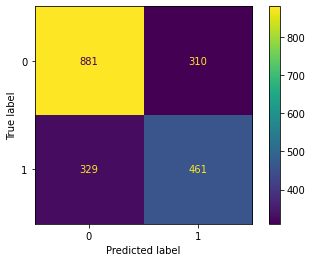

In [327]:
rf = RandomForestClassifier()
rf.fit(imp_training_x, imp_training_y)

predicted_rf = rf.predict(imp_testing_x)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

imp_training_x:<br>
Accuracy:  0.6774<br>
F1:  0.5906<br>
Recall:  0.5835<br>
precision:  0.5979<br>

I will use F1 for general purpose evavluation of modelling.  The widest training set is providing .59 F1.  This is my baseline for the random forest algorithm

random forest with 25 kbest. I want to see how pruning the dataset effects the modelling outputs.

Accuracy:  0.6784
F1:  0.5909
Recall:  0.5823
precision:  0.5997


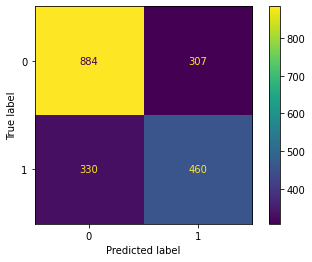

In [372]:
rf = RandomForestClassifier()
rf.fit(X_train_kb25, imp_training_y)

predicted_rf = rf.predict(X_test_kb25)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

imp_training_x:<br>
Accuracy:  0.6774<br>
F1:  0.5906<br>
Recall:  0.5835<br>
precision:  0.5979<br>

X_train_kb25:<br>
Accuracy:  0.6784
F1:  0.5909
Recall:  0.5823
precision:  0.5997

reducing the dataset provided an negligible improvement in 3 out of 4 metrics.  Recall saw a negligible decrease while all other metrics imropved.

random forest with five fewer features: 20 kbest

Accuracy:  0.687
F1:  0.6046
Recall:  0.6
precision:  0.6093


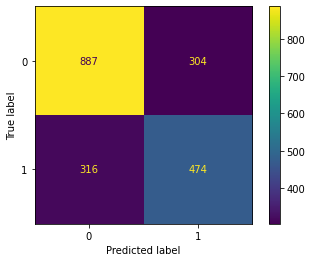

In [373]:
rf = RandomForestClassifier()
rf.fit(X_train_kb20, imp_training_y)

predicted_rf = rf.predict(X_test_kb20)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

X_train_kb25:<br>
Accuracy:  0.6784<br>
F1:  0.5909<br>
Recall:  0.5823<br>
precision:  0.5997<br>

X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6046<br>
Recall:  0.6<br>
precision:  0.6093<br>

This model saw an increase in performance accross all metrics. I am going to proceed with kbest15 to see if this trend continues.

random forest with 15 kbest

Accuracy:  0.6815
F1:  0.6004
Recall:  0.6
precision:  0.6008


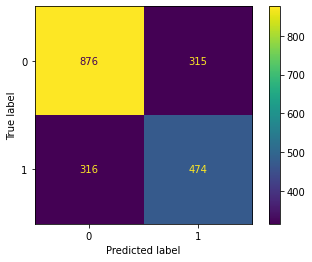

In [374]:
rf = RandomForestClassifier()
rf.fit(X_train_kb15, imp_training_y)

predicted_rf = rf.predict(X_test_kb15)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)  


X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6046<br>
Recall:  0.6<br>
precision:  0.6093<br>

X_train_kb15:<br>
Accuracy:  0.6815<br>
F1:  0.6004<br>
Recall:  0.6<br>
precision:  0.6008<br>

slight decrease in all metrics.  Possible sweet spot between bias and variance at kbest20

Accuracy:  0.6325
F1:  0.5229
Recall:  0.5051
precision:  0.5421


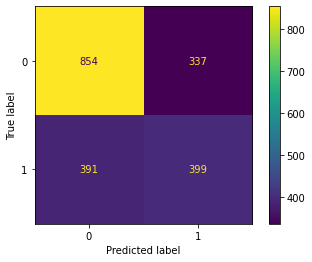

In [376]:
rf = RandomForestClassifier()
rf.fit(holistic_x_train, imp_training_y)

predicted_rf = rf.predict(holistic_x_test)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)  


X_train_kb15:<br>
Accuracy:  0.6815<br>
F1:  0.6004<br>
Recall:  0.6<br>
precision:  0.6008<br>

holistic_x_train<br>
Accuracy:  0.6325<br>
F1:  0.5229<br>
Recall:  0.5051<br>
precision:  0.5421<br>

Massive drop accross all metrics.  Random forest did not like the 'holistic_x_train' set.  Next going to try scaled set.

Accuracy:  0.684
F1:  0.5956
Recall:  0.5835
precision:  0.6082


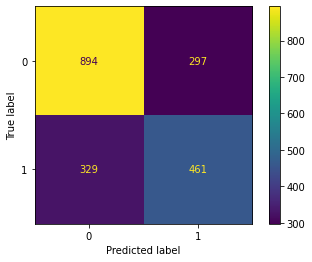

In [377]:
rf = RandomForestClassifier()
rf.fit(X_train_sc, imp_training_y)

predicted_rf = rf.predict(X_test_sc)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6046<br>
Recall:  0.6<br>
precision:  0.6093<br>

X_train_sc:<br>
Accuracy:  0.684<br>
F1:  0.5956<br>
Recall:  0.5835<br>
precision:  0.6082<br>

going to try and parse the scaled set to the kbest 20 that provided the best metrics and run it.

In [384]:
keep_20 = X_train_kb20.columns

In [386]:
X_train_sc_20 = X_train_sc.loc[:,keep_20]
X_test_sc_20 = X_test_sc.loc[:,keep_20]

#X_train_sc_25.head()

going to go ahead and creat a scaled kbest15 set along similiar lines to have a more parsed and interpretable scaled set.

In [387]:
keep_15 = X_train_kb15.columns
X_train_sc_15 = X_train_sc.loc[:,keep_15]
X_test_sc_15 = X_test_sc.loc[:,keep_15]

In [409]:
X_train_kb15.columns

Index(['risk_factors', 'math_b', 'reading_b', 'writing', 'edu_confidence',
       'math_1', 'math_status_1', 'f1_xcurr', 'hs_gpa', 'testing',
       'v_facility', 'm_facility', 'academic_p', 'iq_by_concientiousness',
       'delinquency'],
      dtype='object')

Accuracy:  0.6901
F1:  0.6114
Recall:  0.6114
precision:  0.6114


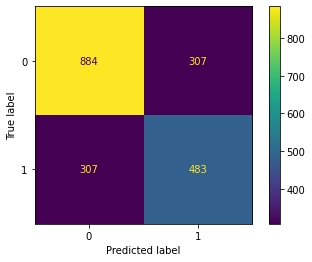

In [388]:
rf = RandomForestClassifier()
rf.fit(X_train_sc_20, imp_training_y)

predicted_rf = rf.predict(X_test_sc_20)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6046<br>
Recall:  0.6<br>
precision:  0.6093<br>

X_train_sc_20:<br>
Accuracy:  0.6901<br>
F1:  0.6114<br>
Recall:  0.6114<br>
precision:  0.6114<br>

best metrics yet.  going forward to tuning.

### Tuning random forest

n_estimators = [int(x) for x in range(90, 150, 10)]<br>
max_features = ['auto']<br>
min_samples_split =[2,4,5]<br>
min_samples_leaf = [1,2]<br>
bootstrap = [True, False]<br>

gid search was run in multiple batches to exhaust possibilities.  the following 'param_grid_rf'

In [627]:
param_grid_rf = {
    'n_estimators':[140],
    'max_features':['auto'],
    'max_depth':[8],
    'min_samples_split':[2],
    'min_samples_leaf':[1],
    'bootstrap':[True],
}

In [628]:
rf = RandomForestClassifier(random_state=13)

In [629]:
clf_rf = GridSearchCV(rf, param_grid_rf,return_train_score = True)
clf_rf.fit(X_train_sc_20,imp_training_y)

GridSearchCV(estimator=RandomForestClassifier(random_state=13),
             param_grid={'bootstrap': [True], 'max_depth': [8],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [140]},
             return_train_score=True)

In [630]:
train_score = np.mean(clf_rf.cv_results_['mean_train_score'])
test_score = clf_rf.score(X_test_sc_20, imp_testing_y)
clf_rf.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 140}

Accuracy:  0.689
F1:  0.6174
Recall:  0.6291
precision:  0.6061


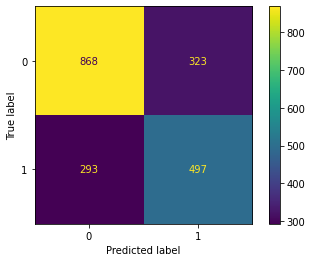

In [392]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_sc_20, imp_training_y)

predicted_rf = rf.predict(X_test_sc_20)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

X_train_sc_20:<br>
Accuracy:  0.6901<br>
F1:  0.6114<br>
Recall:  0.6114<br>
precision:  0.6114<br>

tuned X_train_sc_20:<br>
Accuracy:  0.689<br>
F1:  0.6174<br>
Recall:  0.6291<br>
precision:  0.6061<br>

unexpected drop in accuarcy but all other metrics improved nicely.  When I gridsearched 'bootstrap' the 'False' threw a fail error.  probably because I didn't include 'oob_score' in my gridsearch.  for completeness I am running a model identical to the last but with 'bootstrap' = False.

Accuracy:  0.6875
F1:  0.6177
Recall:  0.6329
precision:  0.6031


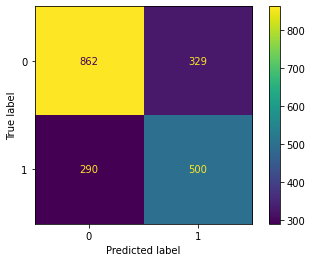

In [393]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_20, imp_training_y)

predicted_rf = rf.predict(X_test_sc_20)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

X_train_sc_20:<br>
Accuracy:  0.6901<br>
F1:  0.6114<br>
Recall:  0.6114<br>
precision:  0.6114<br>

tuned X_train_sc_20:<br>
Accuracy:  0.689<br>
F1:  0.6174<br>
Recall:  0.6291<br>
precision:  0.6061<br>

bootstrap = False:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

bootstrapping 'False' improved F1 and recall slightly.  I am not sure why gridsearch threw an error with it. Trying and unscaled version of the data.

Accuracy:  0.6875
F1:  0.6177
Recall:  0.6329
precision:  0.6031


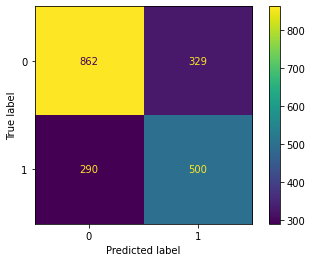

In [395]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_kb20, imp_training_y)

predicted_rf = rf.predict(X_test_kb20)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

bootstrap = False:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

X_train_kb20:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

metrics identical.  Assuming peformance is close to optimal here.  I will run additional models as expirements to see what results parsed dataset give.  parsed sets can provide better understanding of important features.

Accuracy:  0.688
F1:  0.6176
Recall:  0.6316
precision:  0.6041


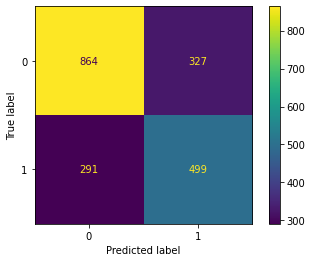

In [396]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_15, imp_training_y)

predicted_rf = rf.predict(X_test_sc_15)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

X_train_kb20, bootstrap = False:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

X_train_sc_15:<br>
Accuracy:  0.688<br>
F1:  0.6176<br>
Recall:  0.6316<br>
precision:  0.6041<br>

metrics on 'X_train_sc_15' are slightly inferior, but comparable to 'X_train_kb20'.  


Testing one with bootstrap = False and oob_score = True

Accuracy:  0.6875
F1:  0.6177
Recall:  0.6329
precision:  0.6031


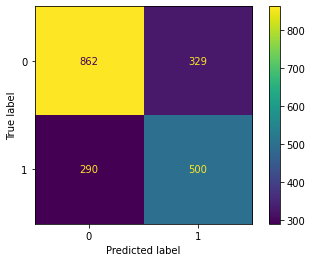

In [397]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_sc_15, imp_training_y)

predicted_rf = rf.predict(X_test_sc_15)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

X_train_sc_15:<br>
Accuracy:  0.688<br>
F1:  0.6176<br>
Recall:  0.6316<br>
precision:  0.6041<br>

X_train_sc_15, oob_score = True:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>


X_train_sc_15, 'oob_score = True' model negligibly inferior

### best random forest

Accuracy:  0.6875
F1:  0.6177
Recall:  0.6329
precision:  0.6031


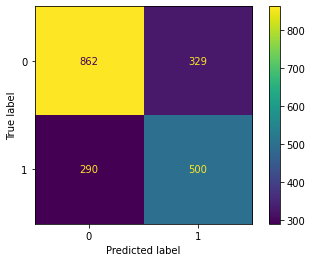

In [411]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_20, imp_training_y)

predicted_rf = rf.predict(X_test_sc_20)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

Baseline:
imp_training_x:<br>
Accuracy:  0.6774<br>
F1:  0.5906<br>
Recall:  0.5835<br>
precision:  0.5979<br>

2nd best but impressive given the feature parsimony:<br>

X_train_sc_15:<br>
Accuracy:  0.688<br>
F1:  0.6176<br>
Recall:  0.6316<br>
precision:  0.6041<br>

Best:<br>

X_train_sc_20:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>



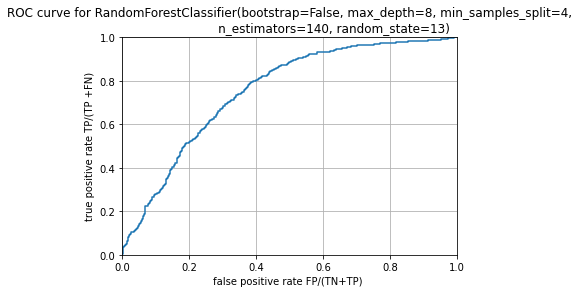

In [404]:
ROC(X_test_sc_20, rf)

X_train_sc_20

In [412]:
X_train_sc_20.columns

Index(['risk_factors', 'math_b', 'reading_b', 'math_conf_b', 'writing',
       'by_xcurr', 'hedonics_b', 'edu_confidence', 'math_1', 'math_status_1',
       'f1_xcurr', 'math_conf_1', 'hs_gpa', 'effort', 'testing', 'v_facility',
       'm_facility', 'academic_p', 'iq_by_concientiousness', 'delinquency'],
      dtype='object')

In [405]:
importances = rf.feature_importances_

[16 12  9 14  8 17  7 18  2  1 15 10  4 19  3 11 13  6  0  5]


<BarContainer object of 20 artists>

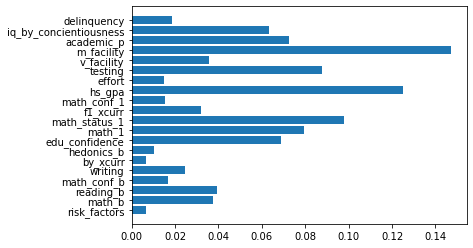

In [414]:
plt.barh(X_train_sc_20.columns, importances)

creating a set parsed down to 3 so I can build a model that performs this classification task that can be visualized with a 3d scatterplot.  This can give a visual reference for modeling.  Also curious to see how a set parsed down to 3 can perform. many of the features I engineered have other features contained in them.   I am picking features that have minimal redundancy and high relevance to the classification task as revealed by these manipulations.  

In [642]:
keep_3 =  ['hs_gpa', 'm_facility', 'edu_confidence' ]
X_train_sc_3 = X_train_sc.loc[:,keep_3]
X_test_sc_3 = X_test_sc.loc[:,keep_3]

Accuracy:  0.684
F1:  0.6206
Recall:  0.6481
precision:  0.5953


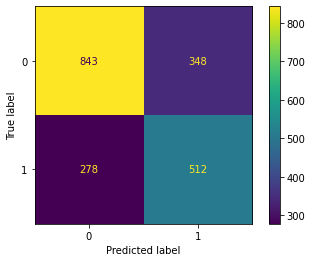

In [644]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_3, imp_training_y)

predicted_rf = rf.predict(X_test_sc_3)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

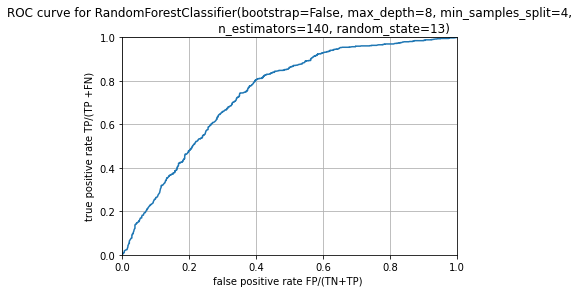

In [645]:
ROC(X_test_sc_3, rf)

X_train_sc_20:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

X_train_sc_3:<br>
Accuracy:  0.684<br>
F1:  0.6206<br>
Recall:  0.6481<br>
precision:  0.5953<br>

for reference - the baseline model using the most inclusive training set 'imp_training_x'<br>
imp_training_x:<br>
Accuracy:  0.6774<br>
F1:  0.5906<br>
Recall:  0.5835<br>
precision:  0.5979<br>

inferior performance, but still impresive given only 3 features.

edu_confidence = what is highest credential the student expects to complete
m_facility = math standardized testing scores times highest math class completed ordinal
academic_p = high school academic load times high school gpa

### logistic regression

Accuracy:  0.6896
F1:  0.5886
Recall:  0.557
precision:  0.6241


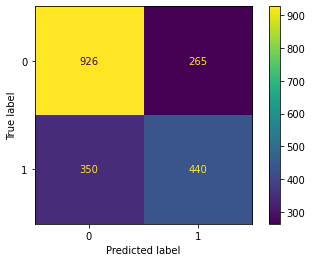

In [646]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(imp_training_x, imp_training_y)

predict_lr = lr.predict(imp_testing_x)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)



baseline logistic regression model using basic and most inclusive training set 'imp_training_x':<br>
Accuracy:  0.6896<br>
F1:  0.5886<br>
Recall:  0.557<br>
precision:  0.6241<br>

for reference the baseline random forest:<br>
imp_training_x:<br>
Accuracy:  0.6774<br>
F1:  0.5906<br>
Recall:  0.5835<br>
precision:  0.5979<br>

precision superior, recall inferior F1 inferior, and accuracy superior to random forest baseline.

Accuracy:  0.684
F1:  0.5793
Recall:  0.5456
precision:  0.6175


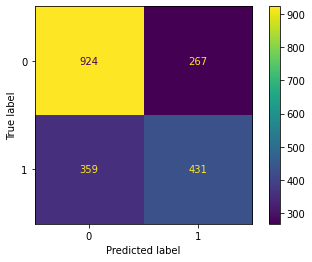

In [647]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_kb25, imp_training_y)

predict_lr = lr.predict(X_test_kb25)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)


imp_training_x:<br>
Accuracy:  0.6896<br>
F1:  0.5886<br>
Recall:  0.557<br>
precision:  0.6241<br>

X_train_kb25:<br>
Accuracy:  0.684<br>
F1:  0.5793<br>
Recall:  0.5456<br>
precision:  0.6175<br>

Slight drop accross all metrics.  Will run several more with more curated sets.

Accuracy:  0.6896
F1:  0.5875
Recall:  0.5544
precision:  0.6248


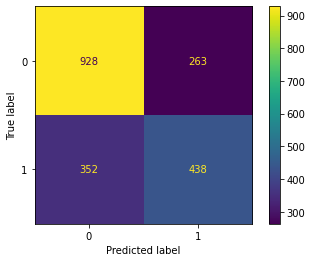

In [648]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_kb20, imp_training_y)

predict_lr = lr.predict(X_test_kb20)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)


X_train_kb25:<br>
Accuracy:  0.684<br>
F1:  0.5793<br>
Recall:  0.5456<br>
precision:  0.6175<br>

X_train_kb20:<br>
Accuracy:  0.6896<br>
F1:  0.5875<br>
Recall:  0.5544<br>
precision:  0.6248<br>

Increases across all metrics with fewer features, possible overfitting with more inclusive datasets.  next: X_train_kb15

Accuracy:  0.6815
F1:  0.5796
Recall:  0.5506
precision:  0.6118


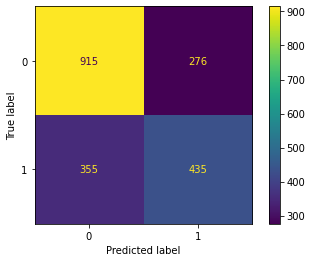

In [649]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_kb15, imp_training_y)

predict_lr = lr.predict(X_test_kb15)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)


X_train_kb20:<br>
Accuracy:  0.6896<br>
F1:  0.5875<br>
Recall:  0.5544<br>
precision:  0.6248<br>

X_train_kb15:<br>
Accuracy:  0.6815<br>
F1:  0.5796<br>
Recall:  0.5506<br>
precision:  0.6118<br>

Slight drops accross all metrics.  Possible increases in bias with more restriction of features.  next: scaled sets

Accuracy:  0.6896
F1:  0.5999
Recall:  0.5835
precision:  0.6171


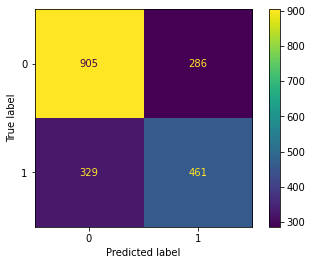

In [650]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_sc, imp_training_y)

predict_lr = lr.predict(X_test_sc)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)


imp_training_x:<br>
Accuracy:  0.6896<br>
F1:  0.5886<br>
Recall:  0.557<br>
precision:  0.6241<br>

X_train_sc:<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

in comparision with the non-scaled version of the dataset the scaled version sees improvement a in recall and F1.  no change in accuracy and slight loss in precision.  going to try a scaled version of the sweet spot at kbest 20 set.  

Accuracy:  0.686
F1:  0.5919
Recall:  0.5709
precision:  0.6144


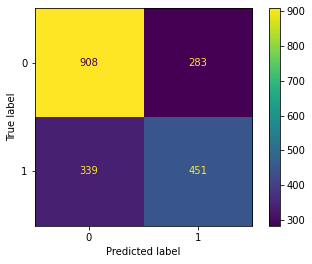

In [651]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_sc_20, imp_training_y)

predict_lr = lr.predict(X_test_sc_20)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)


X_train_sc:<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

X_train_sc_20:<br>
Accuracy:  0.686<br>
F1:  0.5919<br>
Recall:  0.5709<br>
precision:  0.6144<br>

Slight drops accross metrics with recall dropping the most.  So far best results from most inclusive scaled training set.  Next doing 3 feature scaled set just to see results.

Accuracy:  0.6865
F1:  0.5868
Recall:  0.5582
precision:  0.6185


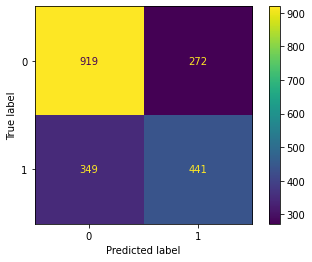

In [652]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_sc_3, imp_training_y)

predict_lr = lr.predict(X_test_sc_3)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

X_train_sc:<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

X_train_sc_3:<br>
Accuracy:  0.6865<br>
F1:  0.5868<br>
Recall:  0.5582<br>
precision:  0.6185<br>

Drops accross all metrics, but precision.  Biggest drop in recall and slight increase in precision.  in comparision to most restriced random forest:

X_train_sc_3:<br>
Accuracy:  0.6795<br>
F1:  0.6024<br>
Recall:  0.6089<br>
precision:  0.596<br>

Note that that random forest is after tuning.  Will compare again on this set sfter tuning.  

### Tuning logistic regression

In [654]:
lr = LogisticRegression(solver='liblinear', random_state=13)

param_grid = {    
    'penalty':['l1','l2'],
    'random_state':[13],
    'C':[1],
    'solver' :['liblinear'], 
    'max_iter':[60,70,80]    
}

In [655]:
clf_lr = GridSearchCV(lr, param_grid, return_train_score = True)
clf_lr.fit(X_train_sc, imp_training_y)

GridSearchCV(estimator=LogisticRegression(random_state=13, solver='liblinear'),
             param_grid={'C': [1], 'max_iter': [60, 70, 80],
                         'penalty': ['l1', 'l2'], 'random_state': [13],
                         'solver': ['liblinear']},
             return_train_score=True)

In [656]:
train_score = np.mean(clf_lr.cv_results_['mean_train_score'])
test_score = clf_lr.score(X_test_sc, imp_testing_y)
clf_lr.best_params_

{'C': 1,
 'max_iter': 60,
 'penalty': 'l1',
 'random_state': 13,
 'solver': 'liblinear'}

Accuracy:  0.6865
F1:  0.5965
Recall:  0.581
precision:  0.6128


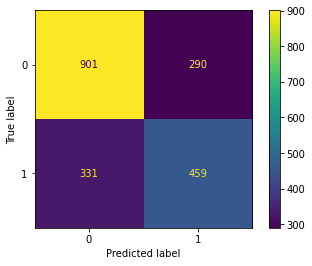

In [657]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 60,random_state=13, C=1,)
lr.fit(X_train_sc, imp_training_y)

predict_lr = lr.predict(X_test_sc)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

X_train_sc:<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

tuned 'X_train_sc':<br>
Accuracy:  0.6865<br>
F1:  0.5965<br>
Recall:  0.581<br>
precision:  0.6128<br>

Slight performance drops after tuning.  Possible overfitting.  Will try with reduced feature set.

Accuracy:  0.688
F1:  0.5971
Recall:  0.5797
precision:  0.6156


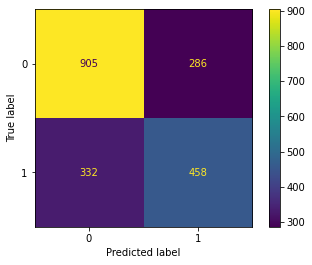

In [658]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 60,random_state=13, C=1,)
lr.fit(imp_training_x, imp_training_y)

predict_lr = lr.predict(imp_testing_x)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

X_train_sc:<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

imp_training_x:1<br>
Accuracy:  0.6881<br>
F1:  0.59711<br>
Recall:  0.57971<br>
precision:  0.61561<br>

scaled version before tuning offering slightly better performance. performance
X_train_sc - before tuning: :<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

results equivalent going to preoceed with sets restriced to 3.

Accuracy:  0.6865
F1:  0.5868
Recall:  0.5582
precision:  0.6185


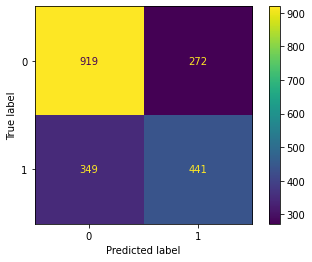

In [659]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(X_train_sc_3, imp_training_y)

predict_lr = lr.predict(X_test_sc_3)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

X_train_sc:<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

X_train_sc_3:<br>
Accuracy:  0.6865<br>
F1:  0.5868<br>
Recall:  0.5582<br>
precision:  0.6185<br>

mild performance drops for most metrics. Impressive given that feature count are reduced from 64 to 3. incomparison to 3 feature set from random forest:<br>

X_train_sc_3:<br>
Accuracy:  0.6795<br>
F1:  0.6024<br>
Recall:  0.6089<br>
precision:  0.596<br>


best logistic regression:

Accuracy:  0.6896
F1:  0.5999
Recall:  0.5835
precision:  0.6171


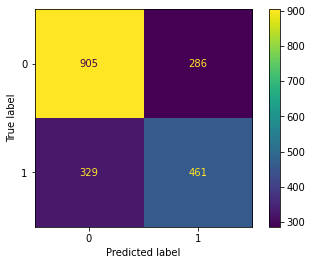

In [660]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_sc, imp_training_y)

predict_lr = lr.predict(X_test_sc)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)


best random forest:<br>
X_train_sc_20:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

best logistic regression:<br>
X_train_sc<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

'X_test_sc' produces best model.  random forest superior on this data for F1 and recall.  logistic regression superior for accuracy and precision.   ROC curve for best logistic regression model:

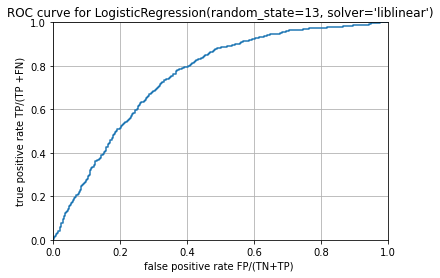

In [661]:
ROC(X_test_sc,lr)

### XGBoost

xgboost with most inclusive set

Accuracy:  0.6825
F1:  0.6071
Recall:  0.6152
precision:  0.5993


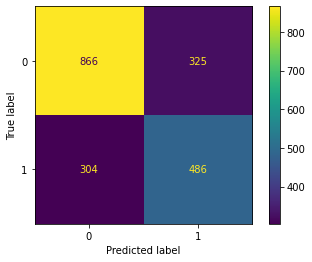

In [662]:
xgb = XGBClassifier()
xgb.fit(imp_training_x,imp_training_y)

predict_xgb = xgb.predict(imp_testing_x)
 
evaluate(imp_testing_y,predict_xgb)

baseline xgboost:<br>
Accuracy:  0.6825<br>
F1:  0.6071<br>
Recall:  0.6152<br>
precision:  0.5993<br>

moving on with pruned sets.  next xgboost with 25 kbest

Accuracy:  0.6764
F1:  0.6036
Recall:  0.6177
precision:  0.5901


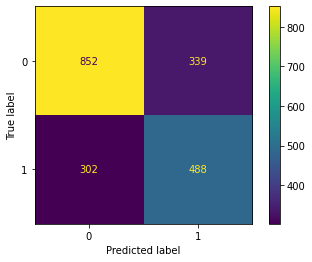

In [663]:
xgb = XGBClassifier()
xgb.fit(X_train_kb25,imp_training_y)

predict_xgb = xgb.predict(X_test_kb25)
 
evaluate(imp_testing_y,predict_xgb)

imp_training_x<br>
Accuracy:  0.6825<br>
F1:  0.6071<br>
Recall:  0.6152<br>
precision:  0.5993<br>

X_train_kb25<br>
Accuracy:  0.6764<br>
F1:  0.6036<br>
Recall:  0.6177<br>
precision:  0.5901<br>


Slight performance reduction with more restricted dataset. Recall improved slightly.  Will continue to reduce features.

xgboost with 20 kbest

Accuracy:  0.68
F1:  0.6062
Recall:  0.6177
precision:  0.5951


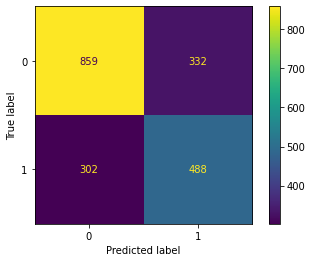

In [664]:
xgb = XGBClassifier()
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

imp_training_x<br>
Accuracy:  0.6825<br>
F1:  0.6071<br>
Recall:  0.6152<br>
precision:  0.5993<br>

X_train_kb25<br>
Accuracy:  0.6764<br>
F1:  0.6036<br>
Recall:  0.6177<br>
precision:  0.5901<br>

X_train_kb20<br>
Accuracy:  0.68<br>
F1:  0.6062<br>
Recall:  0.6177<br>
precision:  0.5951<br>

Kbest20 slight improvement over kbest25 and still slightly inferior to imp_training_x.  Next kbest 15 to see if dimensionality reduction continues to improve.

Accuracy:  0.6769
F1:  0.603
Recall:  0.6152
precision:  0.5912


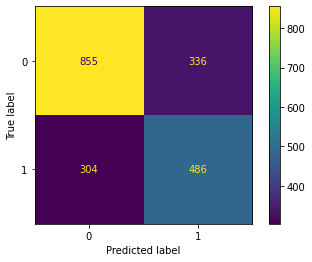

In [666]:
xgb = XGBClassifier()
xgb.fit(X_train_kb15,imp_training_y)

predict_xgb = xgb.predict(X_test_kb15)
 
evaluate(imp_testing_y,predict_xgb)

X_train_kb20<br>
Accuracy:  0.68<br>
F1:  0.6062<br>
Recall:  0.6177<br>
precision:  0.5951<br>

X_train_kb15<br>
Accuracy:  0.6769<br>
F1:  0.603<br>
Recall:  0.6152<br>
precision:  0.5912<br>

slight loss in perfromance.  seems to be sweet spot at 20

Accuracy:  0.68
F1:  0.6077
Recall:  0.6215
precision:  0.5944


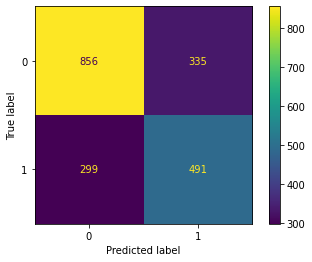

In [667]:
xgb = XGBClassifier()
xgb.fit(x_academics_train,imp_training_y)

predict_xgb = xgb.predict(x_academics_test)
 
evaluate(imp_testing_y,predict_xgb)

imp_training_x<br>
Accuracy:  0.6825<br>
F1:  0.6071<br>
Recall:  0.6152<br>
precision:  0.5993<br>

X_train_kb20<br>
Accuracy:  0.68<br>
F1:  0.6062<br>
Recall:  0.6177<br>
precision:  0.5951<br>

x_academics_train<br>
Accuracy:  0.68<br>
F1:  0.6077<br>
Recall:  0.6215<br>
precision:  0.5944<br>

Best F1 and precision yet on test set with only 11 features trimmed for relevance to academics.  Perhaps noise in more inclusive datasets causing mild overfitting.

xgboost with scaled training set

Accuracy:  0.6825
F1:  0.6071
Recall:  0.6152
precision:  0.5993


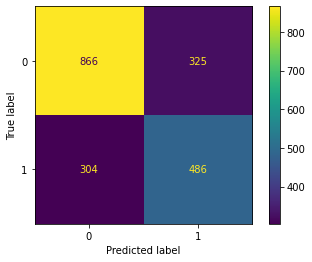

In [668]:
xgb = XGBClassifier()
xgb.fit(X_train_sc,imp_training_y)

predict_xgb = xgb.predict(X_test_sc)
 
evaluate(imp_testing_y,predict_xgb)

imp_training_x<br>
Accuracy:  0.6825<br>
F1:  0.6071<br>
Recall:  0.6152<br>
precision:  0.5993<br>

X_train_sc<br>
Accuracy:  0.6825<br>
F1:  0.6071<br>
Recall:  0.6152<br>
precision:  0.5993<br>

Performance on scaled set identical to non-scaled.

Accuracy:  0.6835
F1:  0.617
Recall:  0.6392
precision:  0.5962


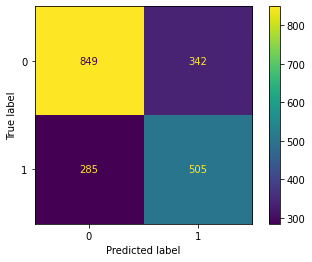

In [669]:
xgb = XGBClassifier()
xgb.fit(X_train_sc_3,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_3)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc<br>
Accuracy:  0.6825<br>
F1:  0.6071<br>
Recall:  0.6152<br>
precision:  0.5993<br>

X_train_sc_3<br>
Accuracy:  0.6835<br>
F1:  0.617<br>
Recall:  0.6392<br>
precision:  0.5962<br>

Highly unexpected.  Rost restrictive dataset with only three features provides marginally better performance.  Best recall and F1, same accuracy and negligibly reduced precision.  will be gridsearching with this set.

### tuning xgboost

In [509]:
# param_grid_xgb = {
#     "n_estimators"     : [70,80,90,110,130,150],
#     'subsample'        : [.7,.8,.9],
#     "learning_rate"    : [.1,.2,.3] ,
#     "max_depth"        : [2,3,4,5],
#     "min_child_weight" : [3,4,5,6,7],
#     "gamma"            : [0.1,.15,.2,.3],
#     "colsample_bytree" : [0.6,.7,.8] 
#     }

started with the above parameter and pruned to these

In [525]:
param_grid_xgb = {
    "n_estimators"     : [90],
    'subsample'        : [.9],
    "learning_rate"    : [.2] ,
    "max_depth"        : [2],
    "gamma"            : [.2],
    "colsample_bytree" : [.7] 
    }

In [526]:
clf_xgb = GridSearchCV(xgb, param_grid_xgb,return_train_score = True)
clf_xgb.fit(X_train_sc_3,imp_training_y)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'colsample_bytree': [0.7], 'gamma': [0.2],
                         'learning_rate': [0.2], 'max_depth': [2],
                         'min_child_weight': [6], 'n_estimators': [80, 90],
                         'subsample': [0.9]},
             return_train_score=True)

In [527]:
train_score = np.mean(clf_xgb.cv_results_['mean_train_score'])
test_score = clf_xgb.score(X_test_sc_3, imp_testing_y)
clf_xgb.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.2,
 'max_depth': 2,
 'min_child_weight': 6,
 'n_estimators': 90,
 'subsample': 0.9}

Accuracy:  0.688
F1:  0.6166
Recall:  0.6291
precision:  0.6046


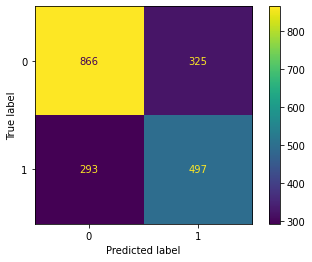

In [670]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_sc_3,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_3)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc<br>
Accuracy:  0.6825<br>
F1:  0.6071<br>
Recall:  0.6152<br>
precision:  0.5993<br>

X_train_sc_3<br>
Accuracy:  0.6835<br>
F1:  0.617<br>
Recall:  0.6392<br>
precision:  0.5962<br>

X_train_sc_3 - tuned:<br>
Accuracy:  0.688<br>
F1:  0.6166<br>
Recall:  0.6291<br>
precision:  0.6046<br>

tuning yields some improvement.  Slight increase in precision and accuracy while others reduced slightly.

slight loss in performance on accuracy but gain in other metrics with kbest15 after tuning.

Accuracy:  0.6865
F1:  0.6131
Recall:  0.6228
precision:  0.6037


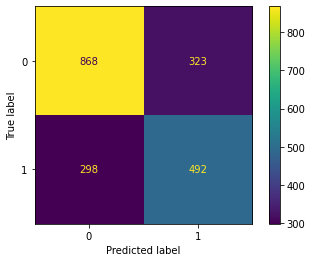

In [671]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_sc,imp_training_y)

predict_xgb = xgb.predict(X_test_sc)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc_3:<br>
Accuracy:  0.688<br>
F1:  0.6166<br>
Recall:  0.6291<br>
precision:  0.6046<br>

X_train_sc<br>
Accuracy:  0.6865<br>
F1:  0.6131<br>
Recall:  0.6228<br>
precision:  0.6037<br>

3 feature mosel still gives better performance over most inclusive set.  perhaps the more inclusive set is causing some overfit.  inclusive scaled set has best accuracy and precision.  trimming to kbest20 next. 

Accuracy:  0.6911
F1:  0.6218
Recall:  0.6367
precision:  0.6075


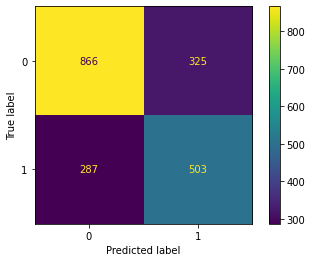

In [672]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_sc_20,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_20)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc_3:<br>
Accuracy:  0.688<br>
F1:  0.6166<br>
Recall:  0.6291<br>
precision:  0.6046<br>

X_train_sc<br>
Accuracy:  0.6865<br>
F1:  0.6131<br>
Recall:  0.6228<br>
precision:  0.6037<br>

X_train_sc_20<br>
Accuracy:  0.6911<br>
F1:  0.6218<br>
Recall:  0.6367<br>
precision:  0.6075<br>

Definitely best metrics yet.  Every metric is superior to models run previously.  3 feature model slight bias while most inclusive sets overfit slightly.  

Accuracy:  0.6911
F1:  0.6218
Recall:  0.6367
precision:  0.6075


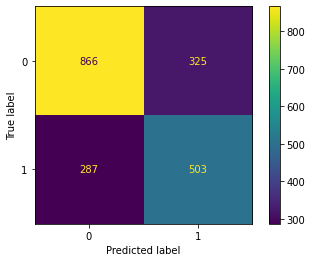

In [539]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc_20<br>
Accuracy:  0.6911<br>
F1:  0.6218<br>
Recall:  0.6367<br>
precision:  0.6075<br>

X_train_kb20<br>
Accuracy:  0.69115<br>
F1:  0.62185<br>
Recall:  0.63675<br>
precision:  0.60755<br>

mild improvement using unscaled set.

#### best xgboost:

Accuracy:  0.6911
F1:  0.6218
Recall:  0.6367
precision:  0.6075


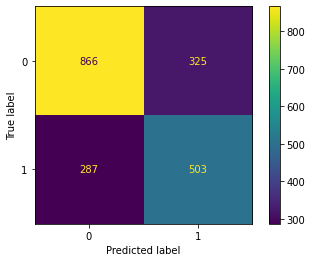

In [674]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

Using inbuilt xgboost feature importances to compare to random forest feature importances.

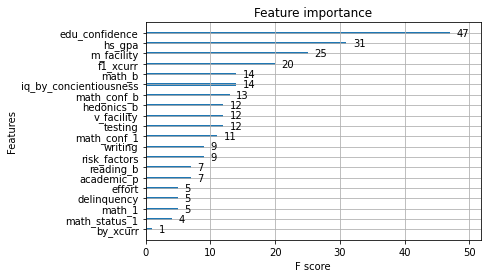

In [675]:
#print("Feature Importances : ", xgb.feature_importances_)
plot_importance(xgb)
plt.show()

xgb importances showing similiar high impact features as random forest importances.

this was the best performance with xgboost.<br>
X_train_kb20<br>
Accuracy:  0.6911<br>
F1:  0.6218<br>
Recall:  0.6367<br>
precision:  0.6075<br>

compared with performance with scaled dataset with only 3 featrues:<br>

X_train_sc_3:<br>
Accuracy:  0.688<br>
F1:  0.6166<br>
Recall:  0.6291<br>
precision:  0.6046<br>

xgboost performs almost as well on this data with a dataset with only 3 features as it does on set with 20.  and compared to the best model from random forest and logistic regression:<br>


best random forest:<br>
X_train_sc_20:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

best logistic regression:<br>
X_train_sc<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

at this point xgboost is providing the best performance.

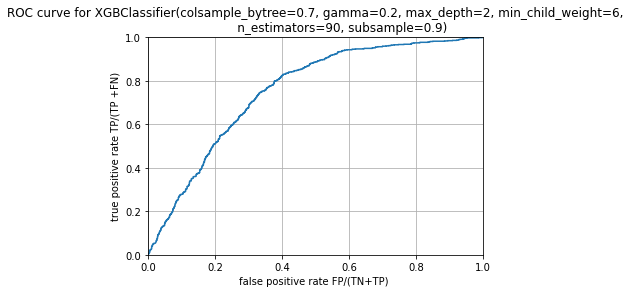

In [676]:
ROC(X_test_kb20,xgb)

### gaussian naive bayes

Accuracy:  0.6759
F1:  0.6592
Recall:  0.7861
precision:  0.5676


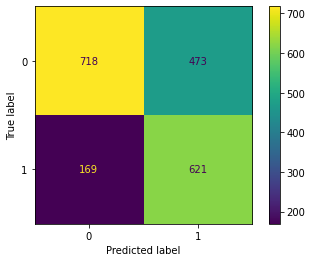

In [677]:
gnb = GaussianNB()

gnb.fit(imp_training_x,imp_training_y)

predict_gnb = gnb.predict(imp_testing_x)

evaluate(imp_testing_y,predict_gnb)


baseline model:<br>
imp_training_x<br>
Accuracy:  0.6759<br>
F1:  0.6592<br>
Recall:  0.7861<br>
precision:  0.5676<br>

baseline model providing best recall, lower precision, modest F1 and accuracy.  going to run progressively trimmed series of sets.

Accuracy:  0.6759
F1:  0.6592
Recall:  0.7861
precision:  0.5676


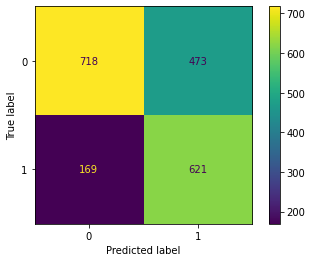

In [678]:
gnb = GaussianNB()

gnb.fit(X_train_kb25,imp_training_y)

predict_nb = gnb.predict(X_test_kb25)

evaluate(imp_testing_y,predict_gnb)

X_train_kb25<br>
Accuracy:  0.6759<br>
F1:  0.6592<br>
Recall:  0.7861<br>
precision:  0.5676<br>

no changes with reduced dimensionality.  going to reduce features down to 20.

Accuracy:  0.6759
F1:  0.6592
Recall:  0.7861
precision:  0.5676


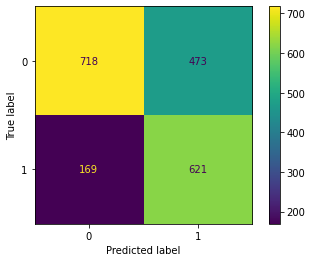

In [679]:
gnb = GaussianNB()

gnb.fit(X_train_kb20,imp_training_y)

predict_nb = gnb.predict(X_test_kb20)

evaluate(imp_testing_y,predict_gnb)

X_train_kb20<br>
Accuracy:  0.6759<br>
F1:  0.6592<br>
Recall:  0.7861<br>
precision:  0.5676<br>

again no movement. going to reduce features further. 

Accuracy:  0.6759
F1:  0.6592
Recall:  0.7861
precision:  0.5676


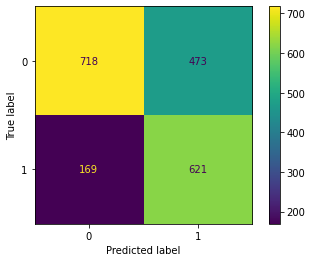

In [680]:
gnb = GaussianNB()

gnb.fit(X_train_kb15,imp_training_y)

predict_nb = gnb.predict(X_test_kb15)

evaluate(imp_testing_y,predict_gnb)

X_train_kb15<br>
Accuracy:  0.6759<br>
F1:  0.6592<br>
Recall:  0.7861<br>
precision:  0.5676<br>

trimmed dataset offer no gain or loss in metrics.going to try scaled set although I doubt scaleing will do anything.

Accuracy:  0.6759
F1:  0.6592
Recall:  0.7861
precision:  0.5676


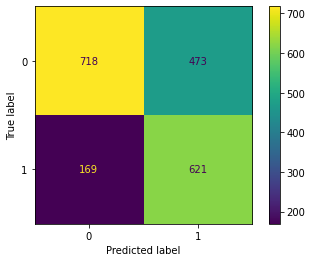

In [681]:
gnb = GaussianNB()

gnb.fit(X_train_sc,imp_training_y)

predict_nb = gnb.predict(X_test_sc)

evaluate(imp_testing_y,predict_gnb)

X_train_sc<br>
Accuracy:  0.6759<br>
F1:  0.6592<br>
Recall:  0.7861<br>
precision:  0.5676<br>

again no change.  will run most restricted set.  

Accuracy:  0.6759
F1:  0.6592
Recall:  0.7861
precision:  0.5676


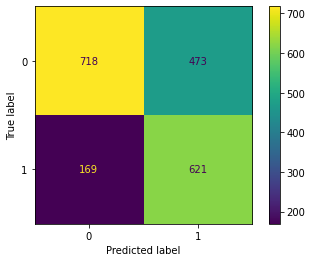

In [682]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_nb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

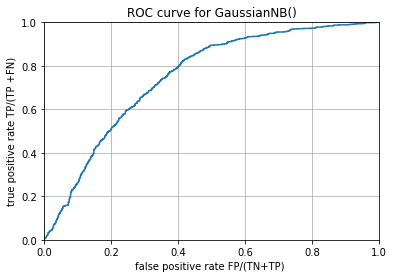

In [683]:
ROC(X_test_sc_3, gnb)

X_train_sc_3<br>
Accuracy:  0.6759<br>
F1:  0.6592<br>
Recall:  0.7861<br>
precision:  0.5676<br>

nothing seems to faze metrics with this algorithm on this these data.  There is not much to tune here so i am moving on to knn

### KNN

Accuracy:  0.6507
F1:  0.5558
Recall:  0.5481
precision:  0.5638


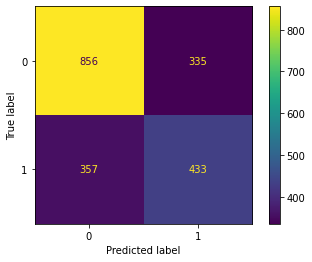

In [684]:
knn = KNeighborsClassifier()

knn.fit(imp_training_x,imp_training_y)

predict_knn = knn.predict(imp_testing_x)

evaluate(imp_testing_y,predict_knn)

baseline model with imp_training_x:<br>
Accuracy:  0.6507<br>
F1:  0.5558<br>
Recall:  0.5481<br>
precision:  0.5638<br>

modest initial performance

Accuracy:  0.6466
F1:  0.5711
Recall:  0.5899
precision:  0.5534


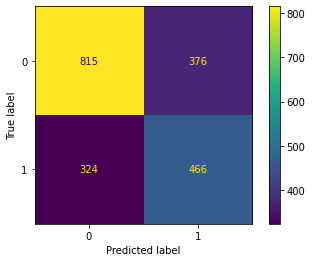

In [685]:
knn = KNeighborsClassifier()

knn.fit(X_train_sc,imp_training_y)

predict_knn = knn.predict(X_test_sc)

evaluate(imp_testing_y,predict_knn)

baseline model with imp_training_x:<br>
Accuracy:  0.6507<br>
F1:  0.5558<br>
Recall:  0.5481<br>
precision:  0.5638<br>

X_train_sc<br>
Accuracy:  0.6466<br>
F1:  0.5711<br>
Recall:  0.5899<br>
precision:  0.5534<br>

scaled yields handsome improvement in F1 and recall, slightly inferior accuarcy and precision.  running unscaled set pruned to 25 features.

Accuracy:  0.6497
F1:  0.5546
Recall:  0.5468
precision:  0.5625


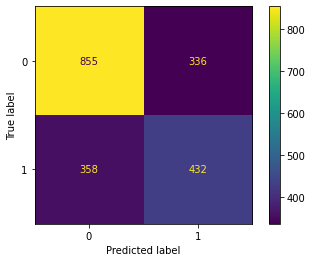

In [686]:
knn = KNeighborsClassifier()

knn.fit(X_train_kb25,imp_training_y)

predict_knn = knn.predict(X_test_kb25)

evaluate(imp_testing_y,predict_knn)

baseline model with imp_training_x:<br>
Accuracy:  0.6507<br>
F1:  0.5558<br>
Recall:  0.5481<br>
precision:  0.5638<br>

X_train_kb25<br>
Accuracy:  0.6497<br>
F1:  0.5546<br>
Recall:  0.5468<br>
precision:  0.5625<br>

negligible drop from baseline.  Continuing to restrict features.

Accuracy:  0.6487
F1:  0.5538
Recall:  0.5468
precision:  0.561


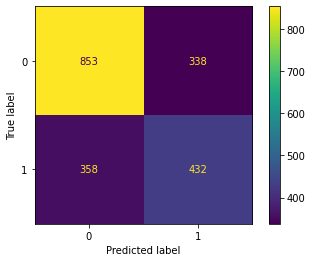

In [687]:
knn = KNeighborsClassifier()

knn.fit(X_train_kb20,imp_training_y)

predict_knn = knn.predict(X_test_kb20)

evaluate(imp_testing_y,predict_knn)

X_train_kb25<br>
Accuracy:  0.6497<br>
F1:  0.5546<br>
Recall:  0.5468<br>
precision:  0.5625<br>

X_train_kb20<br>
Accuracy:  0.6487<br>
F1:  0.5538<br>
Recall:  0.5468<br>
precision:  0.561<br>

mild performance drops continue as number of features gets smaller.

Accuracy:  0.6492
F1:  0.5542
Recall:  0.5468
precision:  0.5618


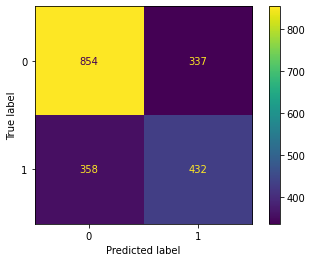

In [688]:
knn = KNeighborsClassifier()

knn.fit(X_train_kb15,imp_training_y)

predict_knn = knn.predict(X_test_kb15)

evaluate(imp_testing_y,predict_knn)

X_train_kb20<br>
Accuracy:  0.6487<br>
F1:  0.5538<br>
Recall:  0.5468<br>
precision:  0.561<br>

X_train_kb15<br>
Accuracy:  0.6492<br>
F1:  0.5542<br>
Recall:  0.5468<br>
precision:  0.5618<br>

Mild increse in performance with further pruned set.  Going to run 3 feature set to.

Accuracy:  0.6562
F1:  0.5615
Recall:  0.5519
precision:  0.5714


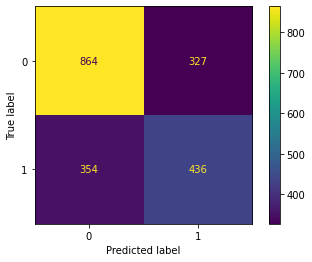

In [689]:
knn = KNeighborsClassifier()

knn.fit(X_train_sc_3,imp_training_y)

predict_knn = knn.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_knn)

X_train_kb15<br>
Accuracy:  0.6492<br>
F1:  0.5542<br>
Recall:  0.5468<br>
precision:  0.5618<br>

X_train_sc_3<br>
Accuracy:  0.6517<br>
F1:  0.5519<br>
Recall:  0.538<br>
precision:  0.5667<br>

highly trimmmed set with only 3 features peforms comparably to more inclusive sets.  precision and accuarcy increase slightly while F1 and recall decrease slightly.
going to gridsearch on 3 feature set for reduced computational load.  from here going to use primarily scaled sets as i suspect knn will like scaled distances better than raw distances.

Accuracy:  0.6537
F1:  0.5786
Recall:  0.5962
precision:  0.5621


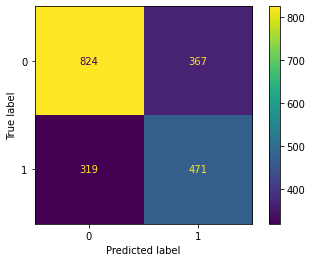

In [694]:
knn = KNeighborsClassifier()

knn.fit(X_train_sc_20,imp_training_y)

predict_knn = knn.predict(X_test_sc_20)

evaluate(imp_testing_y,predict_knn)

imp_training_x<br>
Accuracy:  0.6507<br>
F1:  0.5558<br>
Recall:  0.5481<br>
precision:  0.5638<br>

X_train_sc<br>
Accuracy:  0.6466<br>
F1:  0.5711<br>
Recall:  0.5899<br>
precision:  0.5534<br>

X_train_sc_3<br>
Accuracy:  0.6517<br>
F1:  0.5519<br>
Recall:  0.538<br>
precision:  0.5667<br>

X_train_sc_20<br>
Accuracy:  0.6537<br>
F1:  0.5786<br>
Recall:  0.5962<br>
precision:  0.5621<br>

'X_train_sc_20' provides improved performance over all previous models.  

In [582]:
# param_grid_knn = {
#     'n_neighbors':list(range(50,150,10)), 
#     'leaf_size':[1,2,3], 
#     "p":[1,2,3,4,5],  

#     }

above prams were initial searchspace. trimmed to set below.

In [691]:
param_grid_knn = {
    'n_neighbors':[110], 
    'leaf_size':[1], 
    "p":[3],  

    }

In [692]:
clf_knn = GridSearchCV(knn, param_grid_knn, cv = 5)
clf_knn.fit(X_train_sc, imp_training_y)

GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(leaf_size=1, n_neighbors=110, p=3),
             param_grid={'leaf_size': [1], 'n_neighbors': [110], 'p': [3]})

In [693]:
#train_score = np.mean(clf_knn.cv_results_['mean_train_score'])
test_score = clf_knn.score(X_test_sc, imp_testing_y)
clf_knn.best_params_

{'leaf_size': 1, 'n_neighbors': 110, 'p': 3}

Accuracy:  0.6668
F1:  0.5541
Recall:  0.519
precision:  0.5942


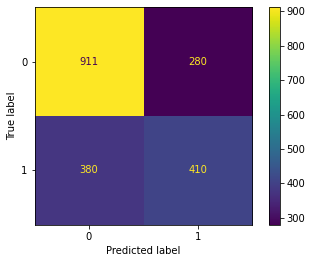

In [690]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc,imp_training_y)

predict_knn = knn.predict(X_test_sc)

evaluate(imp_testing_y,predict_knn)


X_train_sc<br>
Accuracy:  0.6466<br>
F1:  0.5711<br>
Recall:  0.5899<br>
precision:  0.5534<br>

X_train_sc - tuned:<br>
Accuracy:  0.6668<br>
F1:  0.5541<br>
Recall:  0.519<br>
precision:  0.5942<br>

substantive improvement accross all metrics. going to try more restricted sets to maximize interpretability.

scaling gives best performance gain on KNN.  possibly becasue the algorithm relies on distance measures and standard scaling takes noise out of distances

Accuracy:  0.6795
F1:  0.6182
Recall:  0.6506
precision:  0.5888


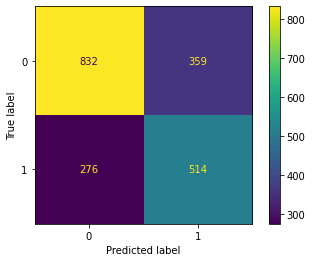

In [695]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_20,imp_training_y)

predict_knn = knn.predict(X_test_sc_20)

evaluate(imp_testing_y,predict_knn)

X_train_sc - tuned:<br>
Accuracy:  0.6668<br>
F1:  0.5541<br>
Recall:  0.519<br>
precision:  0.5942<br>

X_train_sc_20:<br>
Accuracy:  0.6795<br>
F1:  0.6182<br>
Recall:  0.6506<br>
precision:  0.5888<br>

Substantive improvement accross all metrics but presicion.  accuracy, F1 and recall significantly better.  Larger dataset possibly introducing too much noise.  Going to continue to model trimmed sets.

Accuracy:  0.687
F1:  0.6318
Recall:  0.6734
precision:  0.5951


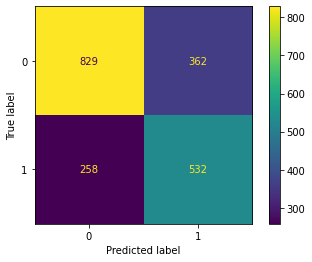

In [696]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_15,imp_training_y)

predict_knn = knn.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_knn)

X_train_sc_20:<br>
Accuracy:  0.6795<br>
F1:  0.6182<br>
Recall:  0.6506<br>
precision:  0.5888<br>

X_train_sc_15:<br>
Accuracy:  0.687<br>
F1:  0.6318<br>
Recall:  0.6734<br>
precision:  0.5951<br>

again substantive increases accross metrics

Accuracy:  0.6784
F1:  0.6001
Recall:  0.6051
precision:  0.5953


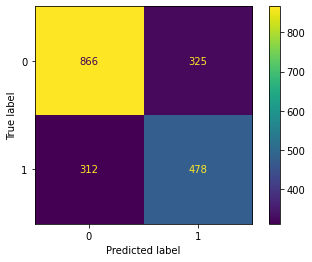

In [697]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_3,imp_training_y)

predict_knn = knn.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_knn)

X_train_sc_15:<br>
Accuracy:  0.687<br>
F1:  0.6318<br>
Recall:  0.6734<br>
precision:  0.5951<br>

X_train_sc_3<br>
Accuracy:  0.6784<br>
F1:  0.6036<br>
Recall:  0.6139<br>
precision:  0.5936<br>

Some significant reduction in performance accross metrics.  X_train_sc_15 is going be the best set as it seems be the best compromise in dimensionality.  

### best knn

Accuracy:  0.687
F1:  0.6318
Recall:  0.6734
precision:  0.5951


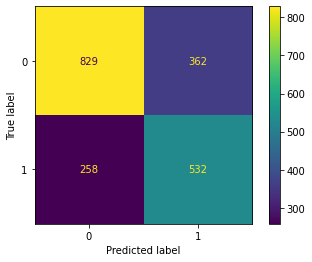

In [698]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_15,imp_training_y)

predict_knn = knn.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_knn)

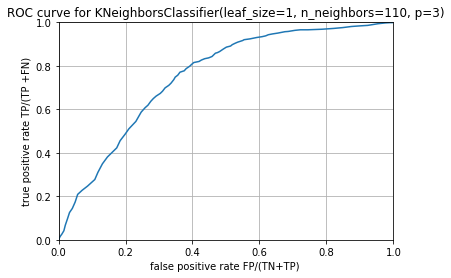

In [699]:
ROC(X_test_sc_15,knn)

best knn: <br>
X_train_sc_15:<br>
Accuracy:  0.687<br>
F1:  0.6318<br>
Recall:  0.6734<br>
precision:  0.5951<br>

knn with 3 feature set yields:<br>

X_train_sc_3<br>
Accuracy:  0.6784<br>
F1:  0.6036<br>
Recall:  0.6139<br>
precision:  0.5936<br>



## best models

## Best Random Forest

Accuracy:  0.6875
F1:  0.6177
Recall:  0.6329
precision:  0.6031


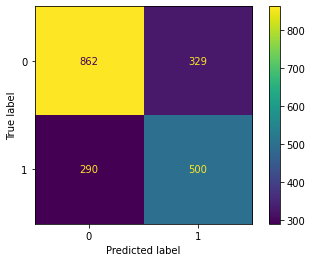

In [700]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_20, imp_training_y)

predicted_rf = rf.predict(X_test_sc_20)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

In [701]:
probs_rf = rf.predict_proba(X_test_sc_20)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(imp_testing_y, probs_rf)
auc_rf = auc(recall_rf, precision_rf)

## Best Logistic Regression

Accuracy:  0.6896
F1:  0.5999
Recall:  0.5835
precision:  0.6171


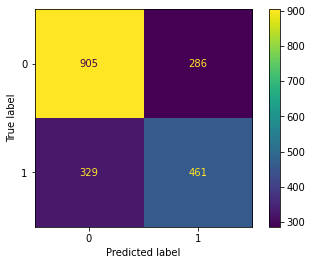

In [702]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_sc, imp_training_y)

predict_lr = lr.predict(X_test_sc)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

In [703]:
probs_lr = lr.predict_proba(X_test_sc)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(imp_testing_y, probs_lr)
auc_lr = auc(recall_lr, precision_lr)

## XGBoost

Accuracy:  0.6911
F1:  0.6218
Recall:  0.6367
precision:  0.6075


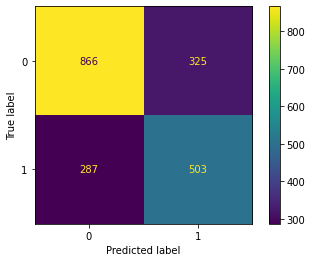

In [704]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

In [705]:
probs_xgb = xgb.predict_proba(X_test_kb20)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(imp_testing_y, probs_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)

## gaussian naive bayes

Accuracy:  0.6759
F1:  0.6592
Recall:  0.7861
precision:  0.5676


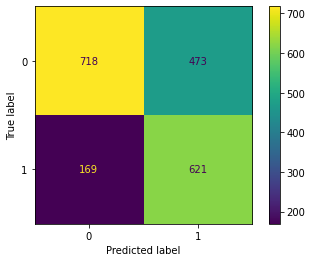

In [706]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_nb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

In [707]:
probs_gnb= gnb.predict_proba(X_test_sc_3)[:, 1]
precision_gnb, recall_gnb, _ = precision_recall_curve(imp_testing_y, probs_gnb)
auc_gnb = auc(recall_gnb, precision_gnb)

### KNN

Accuracy:  0.687
F1:  0.6318
Recall:  0.6734
precision:  0.5951


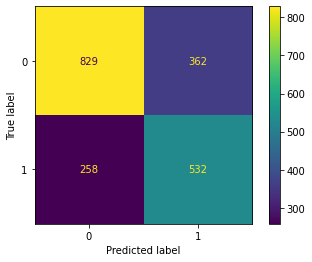

In [708]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_15,imp_training_y)

predict_knn = knn.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_knn)

In [709]:
probs_knn = knn.predict_proba(X_test_sc_15)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(imp_testing_y, probs_knn)
auc_knn = auc(recall_knn, precision_knn)

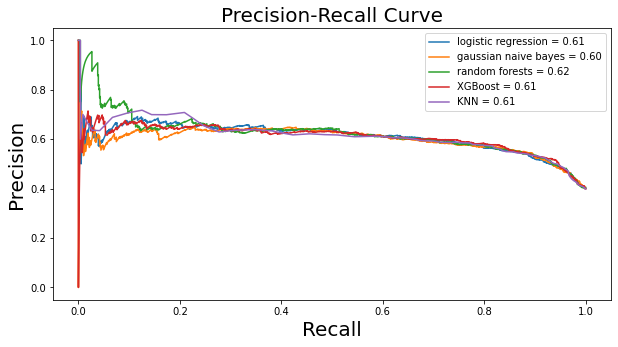

In [710]:
plt.figure(figsize=(10, 5))
plt.plot(recall_lr, precision_lr, label=f'logistic regression = {auc_lr:.2f}')
plt.plot(recall_gnb, precision_gnb, label=f'gaussian naive bayes = {auc_gnb:.2f}')
plt.plot(recall_rf, precision_rf, label=f'random forests = {auc_rf:.2f}')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost = {auc_xgb:.2f}')
plt.plot(recall_knn, precision_knn, label=f'KNN = {auc_knn:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=20)
plt.ylabel('Precision', size=20)
plt.legend();

precision recall curves are usefull visualization for medel evaluation because they visualize how the model is trading off classifying true positives(precision) for a given false negative classification (recall) among different models.  These models are all performing comparably with this trade off .  

xgboost had best accuracy score:<br>
X_train_kb20<br>
Accuracy:  0.6911<br>
F1:  0.6218<br>
Recall:  0.6367<br>
precision:  0.6075<br>

best random forest:<br>
X_train_sc_20:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

logistic regression had best precision:<br>
X_train_sc<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

gaussian niave bayes had best recall and F1:<br>
X_train_sc_3<br>
Accuracy:  0.6759<br>
F1:  0.6592<br>
Recall:  0.7861<br>
precision:  0.5676<br>

best knn: <br>
X_train_sc_15:<br>
Accuracy:  0.687<br>
F1:  0.6318<br>
Recall:  0.6734<br>
precision:  0.5951<br>

### 3 feature models

all models performing comparably in trading off precision and recall.  as comparison I am going to construct a precision recall curve for best 3 featrue models

Accuracy:  0.684
F1:  0.6206
Recall:  0.6481
precision:  0.5953


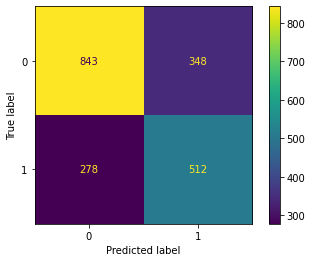

In [711]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_3, imp_training_y)

predicted_rf = rf.predict(X_test_sc_3)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

In [712]:
probs_rf = rf.predict_proba(X_test_sc_3)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(imp_testing_y, probs_rf)
auc_rf = auc(recall_rf, precision_rf)

Accuracy:  0.6865
F1:  0.5868
Recall:  0.5582
precision:  0.6185


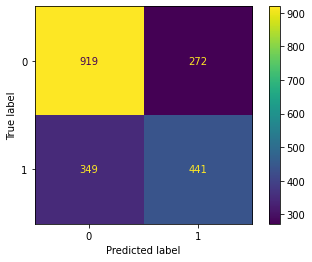

In [713]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(X_train_sc_3, imp_training_y)

predict_lr = lr.predict(X_test_sc_3)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

In [714]:
probs_lr = lr.predict_proba(X_test_sc_3)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(imp_testing_y, probs_lr)
auc_lr = auc(recall_lr, precision_lr)

Accuracy:  0.688
F1:  0.6166
Recall:  0.6291
precision:  0.6046


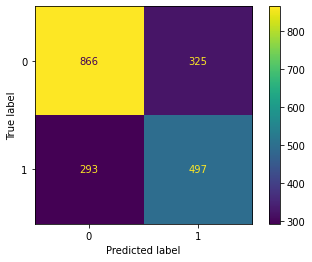

In [715]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_sc_3,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_3)
 
evaluate(imp_testing_y,predict_xgb)

In [716]:
probs_xgb = xgb.predict_proba(X_test_sc_3)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(imp_testing_y, probs_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)

Accuracy:  0.6759
F1:  0.6592
Recall:  0.7861
precision:  0.5676


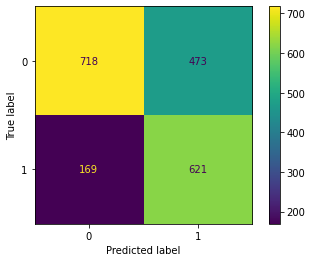

In [717]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_nb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

In [718]:
probs_gnb= gnb.predict_proba(X_test_sc_3)[:, 1]
precision_gnb, recall_gnb, _ = precision_recall_curve(imp_testing_y, probs_gnb)
auc_gnb = auc(recall_gnb, precision_gnb)

Accuracy:  0.6784
F1:  0.6001
Recall:  0.6051
precision:  0.5953


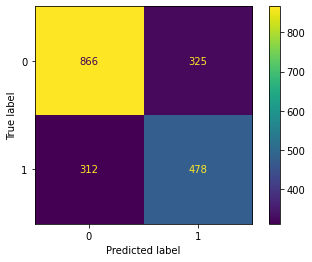

In [719]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_3,imp_training_y)

predict_knn = knn.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_knn)

In [720]:
probs_knn = knn.predict_proba(X_test_sc_3)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(imp_testing_y, probs_knn)
auc_knn = auc(recall_knn, precision_knn)

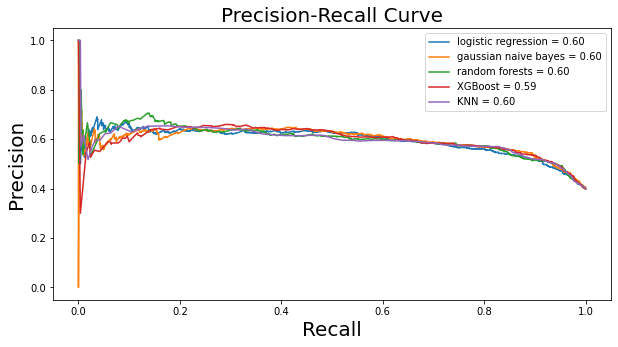

In [721]:
plt.figure(figsize=(10, 5))
plt.plot(recall_lr, precision_lr, label=f'logistic regression = {auc_lr:.2f}')
plt.plot(recall_gnb, precision_gnb, label=f'gaussian naive bayes = {auc_gnb:.2f}')
plt.plot(recall_rf, precision_rf, label=f'random forests = {auc_rf:.2f}')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost = {auc_xgb:.2f}')
plt.plot(recall_knn, precision_knn, label=f'KNN = {auc_knn:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=20)
plt.ylabel('Precision', size=20)
plt.legend();

In [722]:
X_train_sc_3.columns

Index(['hs_gpa', 'm_facility', 'edu_confidence'], dtype='object')

all of these models used the 'X_train_sc_3' dataset.  It is scaled and only has features 'academic_p', 'm_facility', and
'edu_confidence'.  'hs_gpa' is a an estimate of the students grade point average broken down into six categories with ordinal value. 'm_facility' is a feature I constructed by multiplying the students mathematical standasrdized testing score feature by the feature identifying highest math class completed in high schoool.  Math was identified in the exploratory analysis and feature importances as being useful in the classifcation task.  'edu_confidence' was a feature included in the original dataset and corresponds to this highest level of education the student expects to complete.  It an ordinal feature corresponding to achievments like 'phd', 'associates degree', etc... These features were identfied by the feature importances function during the random forest modelling as having the highest influence on correct classification. The 3 feature models are interesting to me because they are directly relevant to the classification task visualized by the 3d scatterplot in the final notebook.<br>

### best 3 feature models:
random forest:<br>
Accuracy:  0.684<br>
F1:  0.6206<br>
Recall:  0.6481<br>
precision:  0.5953<br>

logistic regression:<br>
Accuracy:  0.6865<br>
F1:  0.5868<br>
Recall:  0.5582<br>
precision:  0.6185<br>

xgboost:<br>
Accuracy:  0.688<br>
F1:  0.6166<br>
Recall:  0.6291<br>
precision:  0.6046<br>

gaussian naive bayes:<br>
Accuracy:  0.6759<br>
F1:  0.6592<br>
Recall:  0.7861<br>
precision:  0.5676<br>

knn:<br>
Accuracy:  0.6784<br>
F1:  0.6001<br>
Recall:  0.6051<br>
precision:  0.5953<br>

### best models:
xgboost had best accuracy score:<br>
X_train_kb20<br>
Accuracy:  0.6911<br>
F1:  0.6218<br>
Recall:  0.6367<br>
precision:  0.6075<br>

best random forest:<br>
X_train_sc_20:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

logistic regression had best precision:<br>
X_train_sc<br>
Accuracy:  0.6896<br>
F1:  0.5999<br>
Recall:  0.5835<br>
precision:  0.6171<br>

gaussian niave bayes had best recall and F1:<br>
X_train_sc_3<br>
Accuracy:  0.6759<br>
F1:  0.6592<br>
Recall:  0.7861<br>
precision:  0.5676<br>

best knn: <br>
X_train_sc_15:<br>
Accuracy:  0.687<br>
F1:  0.6318<br>
Recall:  0.6734<br>
precision:  0.5951<br>